In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("googleplaystore.csv") 
#print(data.head())

data[data.Category != '1.9']
data= data.replace('-', np.nan)
data= data.replace('Varies with device', np.nan)

data = data.dropna(axis=0, subset=['Type', 'Content Rating', 'Current Ver', 'Android Ver', 'Reviews', 'Size', 'Rating'])
data['Reviews'] = data['Reviews'].astype(str).astype(int)
data['Size'] = data['Size'].astype(str)

## Deal with app size in kilobytes: silce the original dataframe to include only apps that are in kilobytes. ##
## Strip "Size" column of letters, and convert string to float. ##
kilo = copy.deepcopy(data)
kilo = kilo[kilo['Size'].apply(lambda x: 'k' in x)]
kilo['Size'] = kilo['Size'].map(lambda x: x.rstrip('k')) 
kilo["Size"]= pd.to_numeric(kilo["Size"])


## Deal with app size in Megabytes: silce the original dataframe to include only apps that are in Megabytes. ##
## Strip "Size" column of letters, and convert string to float. ##
## Note: we are working with size in kilobytes, hence why the "Size" column gets multiplied by 1000 ##
mega = copy.deepcopy(data)
mega = mega[mega['Size'].apply(lambda x: 'M' in x)]
mega['Size'] = mega['Size'].map(lambda x: x.rstrip('M')) 
mega["Size"]= pd.to_numeric(mega["Size"]) * 1000
 
    
## Stack the two above dataframes to get the full dataframe again ## 
frames = [kilo, mega]
data = pd.concat(frames)


data['Price'] = pd.to_numeric(data['Price'].astype(str).map(lambda x: x.lstrip('$'))) 
data = data.drop(['Current Ver', 'Android Ver', 'Genres'], axis=1)


## Deal with the "Installs" column: strip punctuation/symbols ##
## Since we have an estimate of the number of installs, we will floor the install values ##
data['Installs'] = data['Installs'].astype(str).map(lambda x: x.rstrip('+'))
data["Installs"] = pd.to_numeric(data["Installs"].str.replace(',', ''))


## Make dictionary where key is the app's category, value is the dataframe containing only that category ##
categories = data.Category.unique()
dict_of_categories = {}
for i in categories:
    dict_of_categories['%s' % i] = None
    mask = data['Category'] == i
    cat_vals = data[mask]
    dict_of_categories['%s' % i] = cat_vals

## Get average rating of app for each category ##
avg_ratings = []
for df in dict_of_categories.values():
    mean = df["Rating"].mean()
    
    avg_ratings.append(mean)


iter_dict = {}
for each in range(0,len(dict_of_categories)-1):
    iter_dict[each] = each
    
## Replace NaN values in the 'Rating' column with the average rating for each category of app ##
filled_in_dict= {}
for (k,v),(k2,v2) in zip(dict_of_categories.items(), iter_dict.items()):
    v = v.fillna(avg_ratings[v2])
    filled_in_dict[k]= v


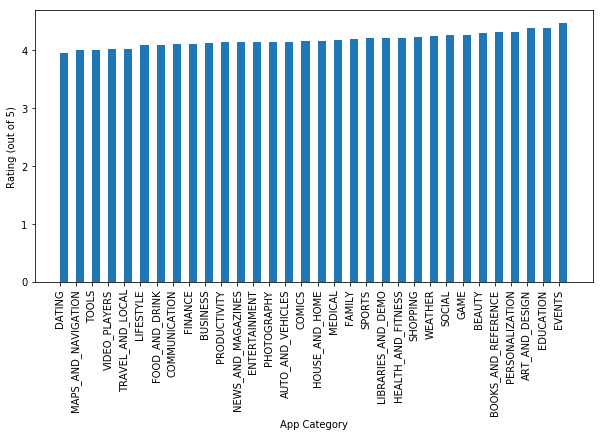

In [2]:
## Graph average ratings for each category of app ###    
## Create rating_dict, where keys are app categories and values are the categorys' average rating ##
## TODO STDEV bars ##
rating_dict = {}

for key, value in filled_in_dict.items():
    rating_dict[key] = value["Rating"].mean()

sorted_rating = {k: v for k, v in sorted(rating_dict.items(), key=lambda x: x[1])} # sort ratings

## make figure ##

plt.figure(figsize=(10, 5))
plt.xticks(rotation = 90)
plt.xlabel ('App Category')
plt.ylabel ('Rating (out of 5)')
plt.bar(sorted_rating.keys(), sorted_rating.values(),align='edge', width=0.5)
plt.show()


# ^^THE ABOVE FIGURE IS INCORRECT
# WILL FIX LATER

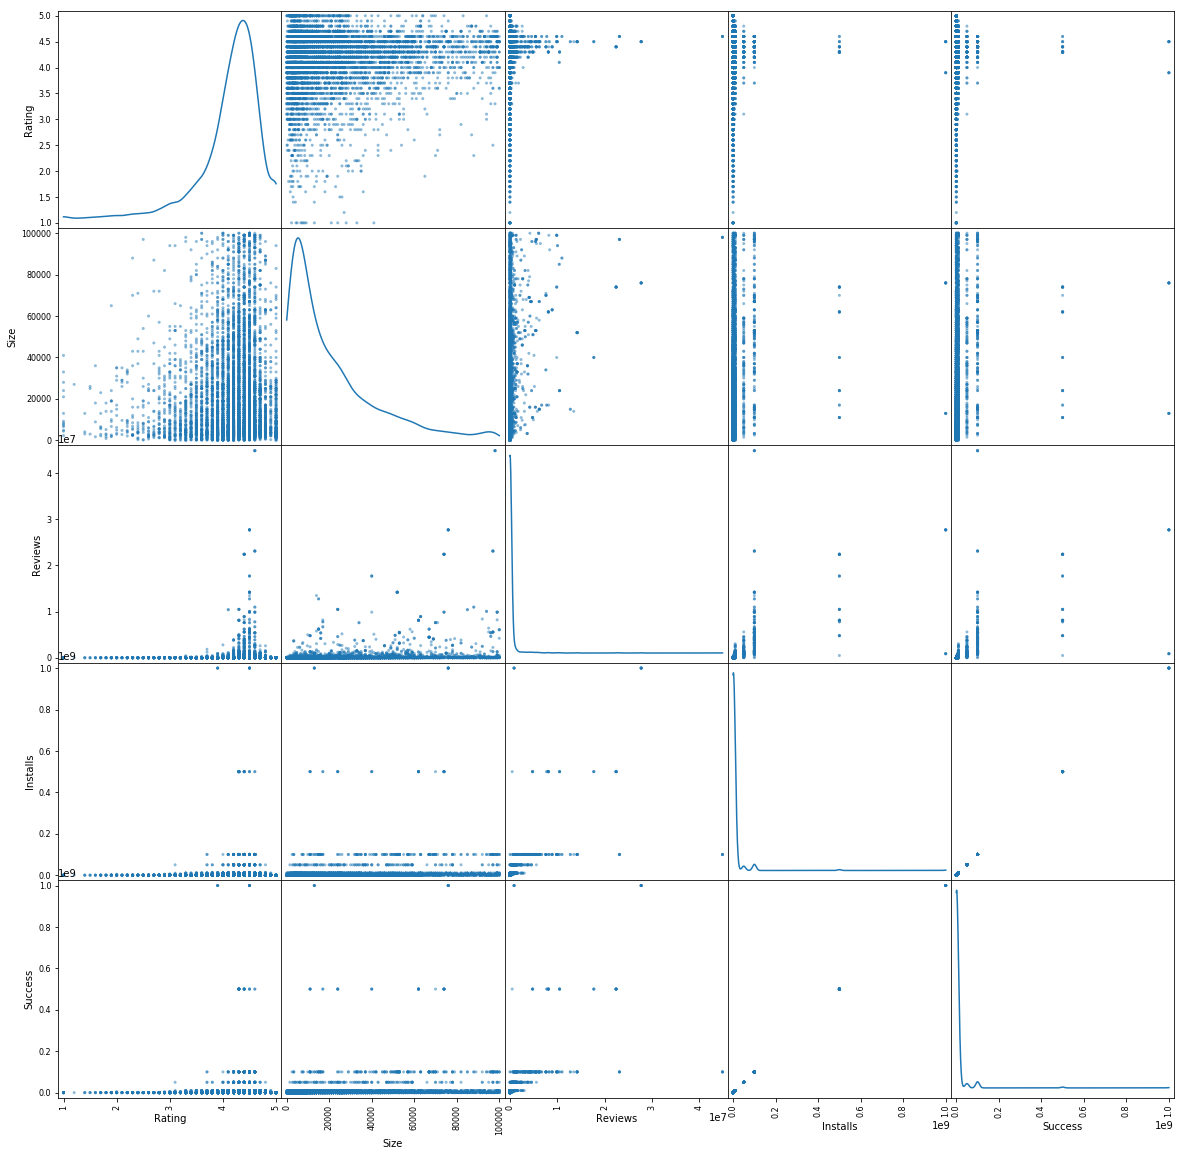

In [3]:

## Create 'Success' feature in original dataframe ##
## Success = #Installs ##
data['Success'] = data['Installs']

## Slice dataframe to include only paid apps ##
data = data[data["Price"] == 0]

## Make scatter matrix to view correlation in data ##
data_for_scattermx = data[['Rating','Size', "Reviews", "Installs", "Success"]]
pd.plotting.scatter_matrix(data_for_scattermx,figsize=(20, 20), diagonal='kde')
plt.show()
#sns.pairplot(data_for_scattermx, diag_kind="kde")


# Finding the Highest and Lowest Rated App Categories

In [4]:
rating_by_category = data.groupby(['Category']).mean()
#print(rating_by_category)
max_rating = rating_by_category["Rating"].max()
min_rating = rating_by_category["Rating"].min()
avg_rating = rating_by_category["Rating"].mean()

print("On average, no app category got rated higher than " + str(max_rating) + " or lower than " + str(min_rating) + "." + "\n")
print("The average rating of apps across all categories is " + str(avg_rating) + "." + "\n")

highest_rated = rating_by_category[rating_by_category['Rating'] == max_rating].index[0]
lowest_rated = rating_by_category[rating_by_category['Rating'] == min_rating].index[0]

print("The highest average rated app category is " + highest_rated + ", and the lowest average rated category is "
      + lowest_rated + '.' + "\n")



On average, no app category got rated higher than 4.47428571429 or lower than 3.96842105263.

The average rating of apps across all categories is 4.18195256707.

The highest average rated app category is EVENTS, and the lowest average rated category is DATING.



# The Installs of Apps

The average number of installs for an app is 8818779.40645.

There are 6833 apps within the 5th percentile of installs.

There are 10 apps greater the 95th percentile of installs.



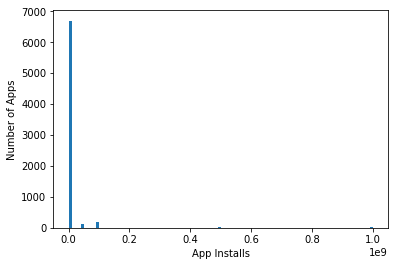

In [5]:
installs = data['Installs']
num_apps = len(installs)
avg_installs = np.mean(installs)
print("The average number of installs for an app is " + str(avg_installs) + "." + '\n')

plt.xlabel ('App Installs')
plt.ylabel ('Number of Apps')
bin_info = plt.hist(installs, bins = 100)
num_in_bins = bin_info[0]
installs_in_bins = bin_info[1]

num_apps_5 = sum(num_in_bins[0:5])
print("There are " + str(int(num_apps_5)) + " apps within the 5th percentile of installs." + '\n')
#Why do we need this data?

num_apps_95 = sum(num_in_bins[95:100])
print("There are " + str(int(num_apps_95)) + " apps greater the 95th percentile of installs." + '\n')
#Why do we need this data?


#df containing apps in the TOP 10% range of number of installs... must have all info ie rating, byte size, etc still
#df_top10 = 

#df containing apps in the TOP 10-20% range of number of installs... must have all info ie rating, byte size, etc still
#df_top10to20 = 

#df containing apps in the TOP 20-30% range of number of installs... must have all info ie rating, byte size, etc still
#df_top20to30 = 

#df containing apps in the middle 30-70% range of number of installs... must have all info ie rating, byte size, etc still
#df_medium =

#df containing apps in the bottom 30% range of number of installs... must have all info ie rating, byte size, etc still
#df_bottom = 


### The relationship between "Success" (dependent variable) and "Reviews" and "Installs" looks rightwards skewed.
### Let's try to log transform the data.

In [6]:
import statsmodels.api as sm



## Thus, our linear model would be Success = b1(log(Installs)) + b0
log_rating = np.log10(data["Rating"])
log_rating = sm.add_constant(log_rating)
model = sm.OLS(data['Success'], log_rating).fit()
predictions = model.predict(log_rating)
print(model.summary())

## Here are our coefficients ##
const = 3.755e+05
b1 = 3.302e+04 


                            OLS Regression Results                            
Dep. Variable:                Success   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     21.68
Date:                Mon, 03 Jun 2019   Prob (F-statistic):           3.27e-06
Time:                        15:35:11   Log-Likelihood:            -1.3546e+05
No. Observations:                7066   AIC:                         2.709e+05
Df Residuals:                    7064   BIC:                         2.709e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.628e+07   5.42e+06     -3.001      0.0

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


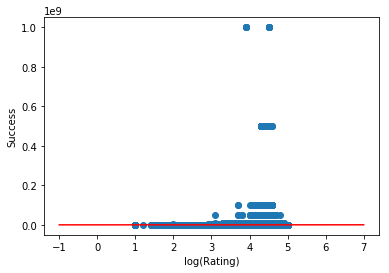

                            OLS Regression Results                            
Dep. Variable:                Success   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     21.68
Date:                Mon, 03 Jun 2019   Prob (F-statistic):           3.27e-06
Time:                        15:35:12   Log-Likelihood:            -1.3546e+05
No. Observations:                7066   AIC:                         2.709e+05
Df Residuals:                    7064   BIC:                         2.709e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.628e+07   5.42e+06     -3.001      0.0

In [7]:
## Let's add in our line of best fit ##

plt.xlabel ('log(Rating)')
plt.ylabel ('Success')
ax = plt.scatter(data["Rating"], data['Success'], marker = "o")

x = np.linspace(-1, 7, 100)
plt.plot(x, const + b1 * x, color = 'r')
plt.show()
print(model.summary())

In [9]:
data

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,Success
58,Restart Navigator,AUTO_AND_VEHICLES,4.0,1403,201.0,100000,Free,0.0,Everyone,"August 26, 2014",100000
209,Plugin:AOT v5.0,BUSINESS,3.1,4034,23.0,100000,Free,0.0,Everyone,"September 11, 2015",100000
384,Hangouts Dialer - Call Phones,COMMUNICATION,4.0,122498,79.0,10000000,Free,0.0,Everyone,"September 2, 2015",10000000
450,Caller ID +,COMMUNICATION,4.0,9498,118.0,1000000,Free,0.0,Everyone,"June 7, 2016",1000000
458,GO Notifier,COMMUNICATION,4.2,124346,695.0,10000000,Free,0.0,Everyone,"July 6, 2014",10000000
768,Pocket GMAT Math,EDUCATION,4.3,656,556.0,10000,Free,0.0,Everyone,"July 11, 2014",10000
775,Pocket SAT Math,EDUCATION,4.0,430,526.0,10000,Free,0.0,Everyone,"July 11, 2014",10000
1019,Mummatikabalkuragi,EVENTS,4.9,69,334.0,1000,Free,0.0,Teen,"July 22, 2018",1000
1521,Aviary Effects: Classic,LIBRARIES_AND_DEMO,3.8,67007,232.0,5000000,Free,0.0,Everyone,"March 6, 2013",5000000
1523,Aviary Stickers: Free Pack,LIBRARIES_AND_DEMO,3.5,126862,624.0,10000000,Free,0.0,Everyone,"January 17, 2012",10000000
